# Libraries
*En este cuadro de codigo tendremos todos los import necesarios para generar y visualizar los graficos*


In [63]:
import pandas as pd
import os
import stylecloud
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from datetime import datetime
from UNLPimage.common.path import PATH_DATA_CSV
from UNLPimage.src.start.start_functions import read_users

# DataFrames
*En este cuadro de código tendremos el acceso a los dataframe necesarios (metadata y logs)*

In [64]:
# Abrimos los CSV y conseguimos los dataframe
path_metadata = os.path.join(PATH_DATA_CSV, "metadata.csv")
data_frame_metadata = pd.read_csv(path_metadata)
path_logs = os.path.join(PATH_DATA_CSV, "logs.csv")
data_frame_logs = pd.read_csv(path_logs)

# Image Types's Graphic
*En este cuadro de código generamos un gráfico de torta que nos mostrará, en función de las imágenes etiquetadas en el archivo metadata.csv, el porcentaje total según cada formato de imágen etiquetada (png, jpg, jpge, webp, etc.)*

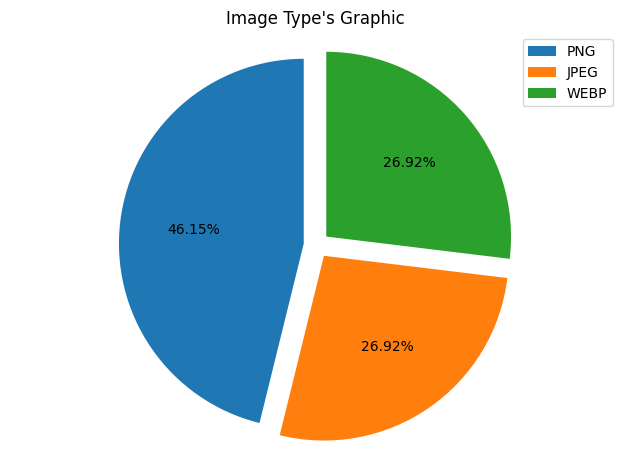

In [65]:
# Conseguimos los datos de las columnas que necesitamos
graphic_data = data_frame_metadata["format"].value_counts()
types = data_frame_metadata["format"].drop_duplicates()

# Dibujado del grafico de torta
plt.style.use("default")
explode = []
for i in range(len(types)):
    explode.append(0.07)
explode = tuple(explode)
plt.pie(
    graphic_data, autopct="%1.2f%%", explode=explode, startangle=90, labeldistance=1.1
)
plt.axis("equal")
plt.legend(types)
plt.title("Image Type's Graphic")
plt.tight_layout()
plt.show()

# Scatter Graph (Width, Height)

El gráfico de dispersión tiene como objetivo mostrar la distribución de los anchos y altos de las imágenes:
* Para este análisis, nos enfocamos en la columna **'resolution'** en el archivo CSV.
* Para poder utilizar los datos de resolución, formateamos la columna de manera adecuada.
* Utilizamos los datos de resolución formateados para generar el gráfico de dispersión, donde cada punto representa una imagen y sus coordenadas corresponden a su ancho y alto.
* Además, asignamos colores aleatorios a cada punto en el gráfico utilizando la biblioteca NumPy.

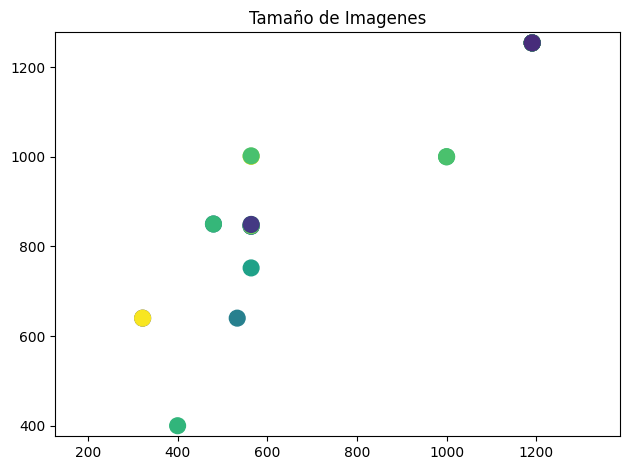

In [66]:
# Obtenemos los datos solicitados (max_width, max_height)
res = (
    data_frame_metadata["resolution"]
    .sort_values()
    .apply(lambda x: tuple(map(int, x.strip("()").split(","))))
)
max_width = res.apply(lambda x: x[0]).max()
max_height = res.apply(lambda x: x[1]).max()

# Generamos una lista de colores random
np.random.seed(19680801)
N = len(res)
colors = np.random.rand(N)

# Generamos el grafico de dispersion
plt.scatter(res.apply(lambda x: x[0]), res.apply(lambda x: x[1]), s=128, c=colors)
plt.axis("equal")
plt.title("Tamaño de Imagenes")
plt.tight_layout()
plt.show()

# Modification's per day graph
*En este cuadro de código generamos un gráfico de barras verticales que, en función de las imágenes etiquetadas (metadata.csv), obtendreamos la cantidad de imágenes etiquetadas para cada día de la semana*

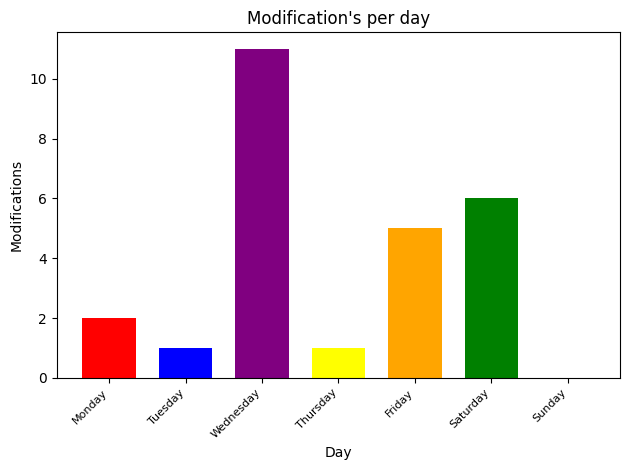

In [67]:
df = data_frame_metadata


def bar_graphic(df, date_field):
    # Creamos la columna dia
    df["day"] = df[date_field].apply(lambda x: datetime.fromtimestamp(x)).dt.day_name()

    # Creamos y 2 DataFrame con los datos intermedios (dias y cantidad)
    # - dias de la semana
    # - valores por cada dia de la semana
    week = pd.DataFrame(
        ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
        columns=["day"],
    )
    days = pd.DataFrame(df["day"].value_counts())

    # Obtenemos el DataFrame final con day, count (incluye dias sin actividad)
    final_df = pd.merge(week, days, on="day", how="outer").fillna(0)

    # Creamos el grafico de barras
    colors = ["red", "blue", "purple", "yellow", "orange", "green", "pink"]
    plt.bar(final_df["day"], final_df["count"], color=colors, width=0.7)
    plt.xticks(range(len(week)), rotation=45, ha="right", fontsize=8)
    plt.title("Modification's per day")
    plt.xlabel("Day")
    plt.ylabel("Modifications")
    plt.tight_layout()
    plt.show()


bar_graphic(df, "last_update")

# Updates across time

El gráfico muestra los cambios en el número de actualizaciones diarias a lo largo del tiempo en los meses en que se realizan actualizaciones:
* Para este análisis, nos enfocamos en la columna **'last_update'** del archivo CSV, que indica cuándo se realizó la última actualización en la aplicación.
* El formato en el que esta **'last_update'** es ilegible, lo formateamos para que sea más legible, aunque con una precisión reducida a meses. Esto evita que el gráfico se sature con demasiada información.

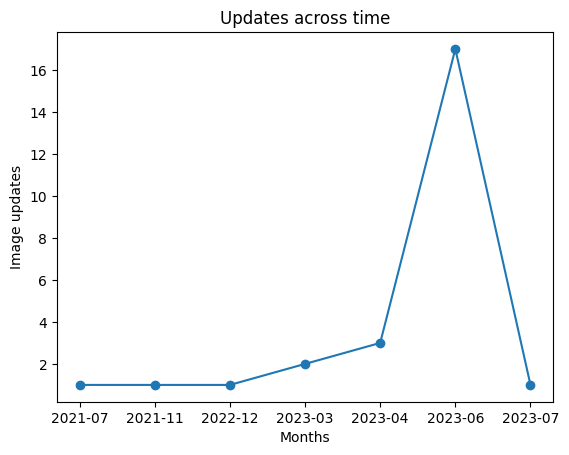

In [68]:
# Obtenemos los datos de la columna last_update
dates = data_frame_metadata.copy()["last_update"]

# Trabajamos el formato y orden de la fecha
count_by_dates = (
    dates.apply(lambda x: datetime.fromtimestamp(x).strftime("%Y-%m"))
    .value_counts()
    .sort_index()
)
# Creamos el grafico
plt.title('Updates across time')
plt.ylabel('Image updates')
plt.xlabel('Months')
plt.plot(count_by_dates, marker="o")
plt.show()

# Tag's Word Cloud
*En este cuadro de código generamos una nube de palabras, utilizando como fuente de palabras todos los tags de todas las imagenes que se etiquetaron en la aplicación*

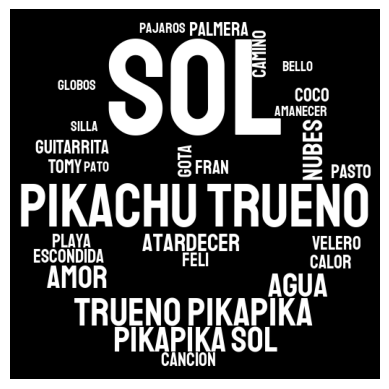

In [69]:
# Obtenemos la informacion de los tags, aquellos sin tags aparecen como NaN por tanto que hay sacarlos.
data = data_frame_metadata["tags"].dropna()


# Generamos un string con todos los tags
tags_str = ""
for word in data:
    if ";" in word:
        tags_str += " " + word.strip().replace(";", " ")
    else:
        tags_str += " " + word


# Creamos la nube de palabras
stylecloud.gen_stylecloud(
    tags_str,
    icon_name="fas fa-smile",
    colors="white",
    background_color="black",
)
plt.imshow(plt.imread("stylecloud.png"))
plt.axis("off")
plt.show()

# 3 Most Used Tags
*En este cuadro de código generamos un dataframe que contiene las 3 etiquetas mas usadas entre todas las imágenes*

In [70]:
# Obtenemos la informacion de los tags
data = data_frame_metadata["tags"].dropna()

# Generamos una lista con todos los tags
tags_list = []
for tags in data:
    if ";" in tags:
        words = [word.strip() for word in tags.split(";")]
        tags_list += words
    else:
        tags_list.append(tags.strip())

# Obtenemos los 3 que mas se repitieron
max_3 = Counter(tags_list).most_common(3)

# Creamos un nuevo DataFrame con los datos correspondientes al grafico
new_df = pd.DataFrame(max_3, columns=["tag", "reps"])
new_df

,tag,reps
0,sol,21
1,pikachu,9
2,trueno,9


# Prom Size's Image Modifications
*En este cuadro de código generamos un dataframe que contiene para todos los usuarios de la aplicación, el promedio de peso de las imágenes etiquetadas, en caso de no haber etiquetado ninguna imágen, el promedio será 0.0*

In [71]:
df = data_frame_metadata

# Obtenemos los nick de todos los usuarios existenes
# y el promedio del peso de imagenes que han modificado
all_users = [x["nick"] for x in read_users()]
size_data = df.groupby("current_user")["size_mb"].mean().round(4)

# Generamos un Json donde si el usuario modifico ponemos el promedio modificado
# de haber echo nunca una modificacion se lista con promedio 0
new_data = []
for user in all_users:
    if user in size_data:
        new_data.append({"nick": user, "prom_size_mb": f"{size_data[user]}"})
    else:
        new_data.append({"nick": user, "prom_size_mb": "0.0"})

# Creamos un nuevo DataFrame con los datos correspondientes al grafico
new_df = pd.DataFrame(new_data)
new_df

,nick,prom_size_mb
0,elnicky,0.0
1,perca,0.075
2,massa,0.0853
3,alva,0.0523
4,tomas,0.0582
5,mariposa,0.0
6,pepito,0.0


# Logs Operation per day
*En este cuadro de código llamamos a la función propia 'bar_graphic()', a la cual pasamos como parámetro el dataframe de 'logs.csv' y el string 'date' el cual se corresponde con la columna que identifica el timestamp en que se realizó ese log del sistema. Entonces obtendremos un gráfico de barras que, en funcion del día en que fue realizado cada log, nos mostrará para cada día de la semana la cantidad de logs que se registraron en la aplicación*

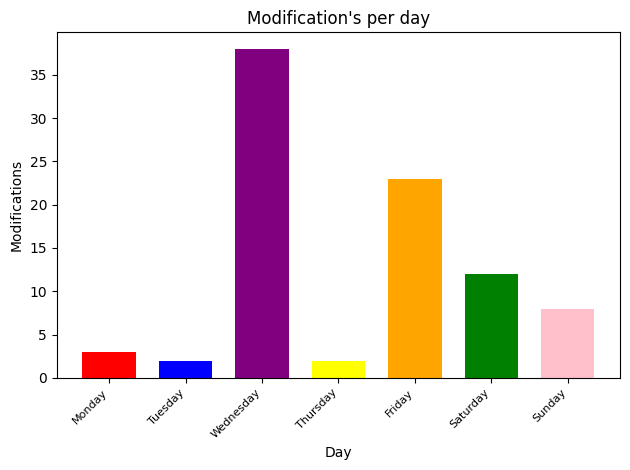

In [72]:
df = data_frame_logs

bar_graphic(df, "date")

# Use by gender
*En este cuadro de código generamos un gráfico de torta a partir de:*

 *- logs del sistema 'logs.csv' (nick de usuario + cantidad de apariciones en el log).*
 
 *- Usuarios del sistema 'usuarios.json' (nick de usuario + género).*
 
*Entonces podremos obtener para cada género (pre existentes o géneros fluidos ingresados por el usuario) la cantidad de logs del sistema que realizo cada genero*

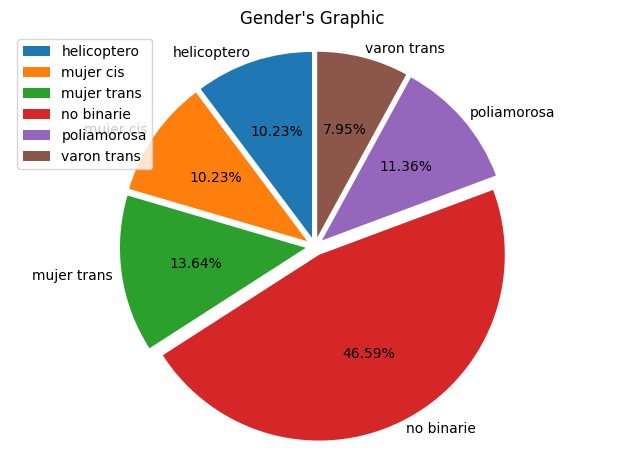

In [73]:
logs_df = data_frame_logs

# Obtengo un Json con todos los nick, gender y genero un DataFrame
all_users = read_users()
data = []
for user in all_users:
    data.append({"nick": user["nick"], "gender": user["gender"]})

# Obtengo un nuevo DataFrame, con el [nick, gender] de todos usuarios existenes
new_df = pd.DataFrame(data, columns=["nick", "gender"])

# Obtengo el total de generos, pre-existentes o opcionales set(all_genders)
all_genders = set(
    ["varon cis", "varon trans", "mujer cis", "mujer trans", "no binarie", "otre"]
)
reps = new_df["gender"].value_counts()
for gender, qty in reps.items():
    all_genders.add(gender)


# Obtengo una Series con la cantidad de actualizaciones en el log por usuario
logs = logs_df.value_counts("nick")


# Genero un nuevo DataFrame con nick, genero, logs
gender_df = pd.merge(new_df, logs, how="outer", on="nick")


# DataFrame con todos los generos existentes + opcionales
final_df = pd.DataFrame(list(all_genders), columns=["gender"])


# Genero el DataFrame final con genero, logs
final_df = pd.merge(final_df, gender_df, how="inner", on="gender").drop("nick", axis=1)
final_df = final_df.groupby("gender")["count"].sum()

# Muestro el grafico de torta segun los logs de cada genero
plt.style.use("default")
explode = []
for i in range(len(final_df)):
    explode.append(0.05)
explode = tuple(explode)
plt.pie(
    final_df,
    autopct="%1.2f%%",
    labels=final_df.index,
    explode=explode,
    startangle=90,
    labeldistance=1.05,
)
plt.axis("equal")
plt.legend(final_df.index)
plt.title("Gender's Graphic")
plt.tight_layout()
plt.show()

# Bar Graphic per action
*En este cuadro de código generamos un gráfico de barras que, en función del tipo de operación de cada log del sistema:*

 *- "Dio de alta su usuario"*

 *- "Edito su usuario"*

 *- "Modificación de la configuración"*

 *- "Modificación a imagen previamente clasificada"*
 
 *- "Nueva imagen clasificada"*
 
*Obtendremos entonces el total de repeticiones en el log de cada operacion disponible**

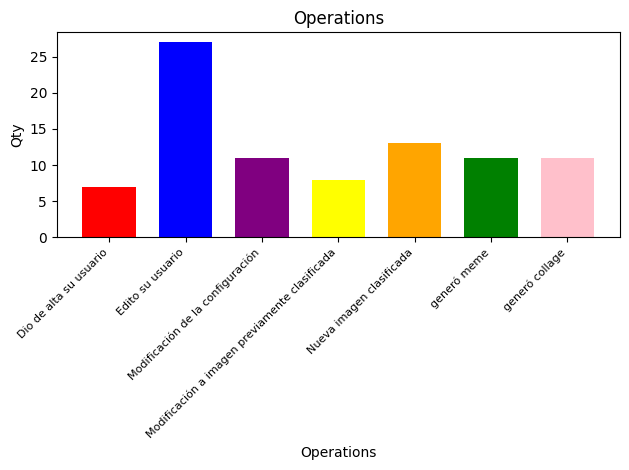

In [74]:
logs_df = data_frame_logs

# Creamos 3 estructuras con los datos necesarios para el grafico
# - colores
# - operaciones posibles
# - cantidad de operaciones (por operacion)
colors = ["red", "blue", "purple", "yellow", "orange", "green", "pink"]
operations = pd.DataFrame(
    [
        "Dio de alta su usuario",
        "Edito su usuario",
        "Modificación de la configuración",
        "Modificación a imagen previamente clasificada",
        "Nueva imagen clasificada",
    ],
    columns=["operation"],
)
qty = pd.DataFrame(logs_df["operation"].value_counts())

# Obtengo la estructura final con operation, qty (se hayan realizado o no)
final_df = pd.merge(operations, qty, on="operation", how="outer").fillna(0)

# Creamos el grafico de barras
plt.bar(final_df["operation"], final_df["count"], color=colors, width=0.7)
plt.xticks(range(len(final_df["operation"])), rotation=45, ha="right", fontsize=8)
plt.title("Operations")
plt.xlabel("Operations")
plt.ylabel("Qty")
plt.tight_layout()
plt.show()

# Operations per user
*En este cuadro de código generamos un gráfico de barras horizontal que, en función de las operaciones registrada de cada usuario en el log del sistema:*

 *- "Dio de alta su usuario"*

 *- "Edito su usuario"*

 *- "Modificación de la configuración"*

 *- "Modificación a imagen previamente clasificada"*
 
 *- "Nueva imagen clasificada"*

 *Obtendremos entonces para cada usuario el total de logs registrados de cada operacion disponible en el sistema*


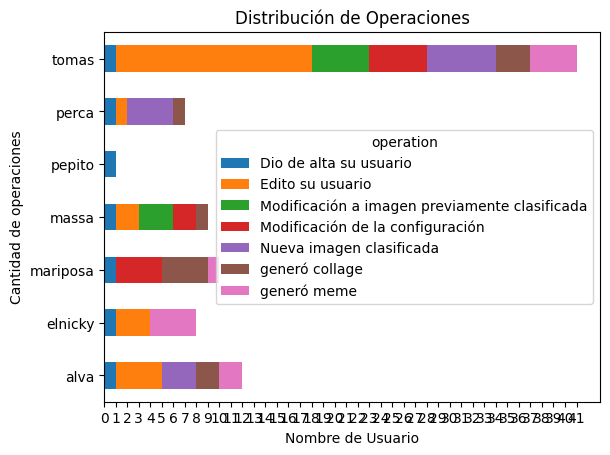

In [75]:
logs_df = data_frame_logs
operation_count = logs_df.groupby(['nick', 'operation']).size().reset_index(name='count')
max_value = operation_count.groupby('nick')['count'].sum().max()
grouped_data = logs_df.groupby(['nick', 'operation']).size().unstack()
x_ticks = range(max_value+1)

# Trazar el gráfico de barras
grouped_data.plot(kind='barh', stacked=True)

# Establecer las posiciones y etiquetas de marca del eje x
plt.xticks(x_ticks)
# Establecer las etiquetas de marca del eje x
plt.gca().set_xticklabels(x_ticks)

# Establecer las etiquetas y el título
plt.xlabel("Nombre de Usuario")
plt.ylabel('Cantidad de operaciones')
plt.title("Distribución de Operaciones")
# Mostramos el Grafico
plt.show()



# Most used images for collage

Esta tabla muestra las 5 imagenes más usadas para crear un collage. 

Para conseguir el dato lo que hacemos es quedarnos con aquellas filas cuya operacion sea generar collage, luego convertimos los datos a algo que se pueda usar y con ello contablizamos cuantas veces se repite la imagen.

In [76]:
# Filtramos el dataframe para tener aquelos que tengan que ver con collage:
logs_df = data_frame_logs[(data_frame_logs["operation"] == "generó collage")]
# Transformamos los valores de la columna values en una lista en sí, porque antes eran un string:
images_series = logs_df["values"].apply(eval)
# Hacemos que cada uno de los elementos de la lista este individualmente en vez de juntos en una lista y lo hacemos una serie:
images_count = pd.Series([image for images in images_series for image in images])
# Contabilizamos y hacemos los cambios para que se vean lindos:
image_count = (
    images_count.value_counts().reset_index().rename(columns={"index": "image"})
)
image_count.head(5)

,image,count
0,atardecer.jpg,10
1,caminos.jpg,5
2,escondida.jpg,4
3,-stitch-elvis.png,4
4,pikachu.png,4


# Most used images for memes

Esta tabla muestra las 5 imagenes más usadas para crear un meme. 

Para conseguir el dato lo que hacemos es quedarnos con aquellas filas cuya operacion sea generar meme, y con ello contablizamos cuantas veces se repite la imagen.

In [77]:
# Filtramos el dataframe para tener aquelos que tengan que ver con meme:
logs_df = data_frame_logs[(data_frame_logs["operation"] == "generó meme")]
# Conseguimos las imagenes
images_series = logs_df["values"]
# Contabilizamos y hacemos los cambios para que se vean lindos:
images_series = (
    images_series.value_counts().reset_index().rename(columns={"index": "image"})
)
images_series.head(5)

,values,count
0,monito.png,3
1,dragones.png,3
2,botoncitos.png,3
3,pibe_campera.png,1
4,cerebrones.png,1


# Wordcloud with the text added to the collage and memes

El objetivo de este gráfico es crear una representación visualmente atractiva de las palabras que los usuarios introdujeron a la hora de ponerle nombre al collage o los textos que ponen en los memes:
* Para generar la nube de palabras, leemos el contenido de la columna **'text'** en el archivo CSV de logs.
* Extraemos los datos de **'text'** y los utilizamos para construir la nube de palabras.

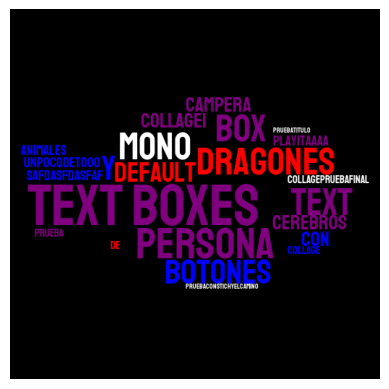

In [78]:
# Obtenemos la informacion de los tags
data = data_frame_logs["text"].dropna()

# Generamos un string con todos los tags
texts_str = ""
for text in data:
    texts_str += " " + text


# Creamos la nube de palabras
stylecloud.gen_stylecloud(
    texts_str,
    icon_name="fas fa-fish",
    colors=["red", "white", "blue", "purple"],
    background_color="black",
)
plt.imshow(plt.imread("stylecloud.png"))
plt.axis("off")
plt.show()

# Operations per Gender
Este grafico en forma de torta tiene la intención de representar por genero cuantas operaciones de tipo **'Nueva imagen clasificada'** y **'Modificación a imagen previamente clasificada'**.
Para conseguir eso segui los siguientes pasos: 
* Del CSV de logs me quedo con aquellas filas que tengas de operación una de las mencionadas anteriormente.
* Luego reordeno los datos para que esten agrupados en funcion del nick y la operación.
* Con los los datos agrupados contamos el tamaño de cada grupo y lo ponemos sobre la columna count.
* Luego necesitamos reemplazar los datos que tenemos (los nicks) por su respectivo genero (dato que esta en el JSON de usuarios), para ello leemos el json de usuarios y en base a eso reemplazamos cada nick por el genero que le toca.


Después de ese procesamiento ya estamos listos para mostrar los datos. Cada porcentaje representa el total que se hizo de esa operación por genero, las etiquetas son el genero que lo hizo, y la leyenda indica que operación se hizo.

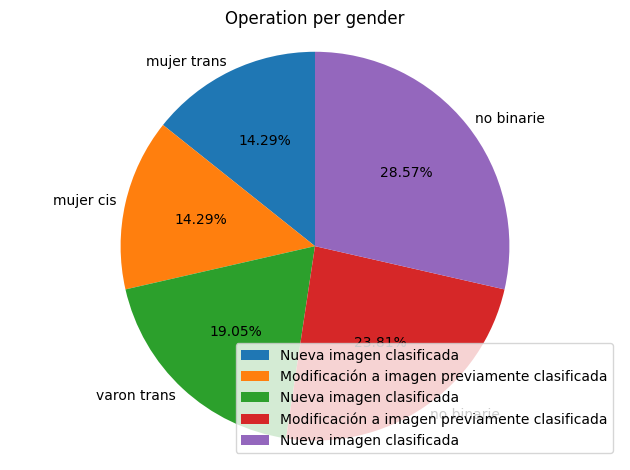

In [79]:
# Conseguimos solamente aquellas filas en las cuales se produjo una clasificación:
user_operation_dataframe = data_frame_logs[
    data_frame_logs["operation"].isin(
        ["Nueva imagen clasificada", "Modificación a imagen previamente clasificada"]
    )
]
# Agrupamos por nick y operacion
user_operation_dataframe = (
    user_operation_dataframe.groupby(["nick", "operation"])
    .size()
    .reset_index(name="count")
)
users = read_users()
# Creamos un diccionario donde quede el nick y su genero juntos.
gender_dict = {user["nick"]: user["gender"] for user in users}

# Creamos una nueva columna con los generos de cada una.
user_operation_dataframe["gender"] = user_operation_dataframe["nick"].map(gender_dict)
# Eliminamos los nicks ya que no nos importan.
df_user = user_operation_dataframe.drop("nick", axis=1)

plt.pie(
    df_user["count"],
    autopct="%1.2f%%",
    labels=df_user["gender"],
    startangle=90,
    labeldistance=1.05,
)
plt.axis("equal")
plt.title("Operation per gender")
plt.legend(df_user["operation"])
plt.tight_layout()
plt.show()